In [1]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.callback import EarlyStopping
import json


In [2]:
CAT_COLS = ['type', 'subtype', 'size_category', 'temperature', 'above_median_access_count', 'above_median_filesize']
NUM_COLS = ['stddev_access_date',
 'dt_last_access_date',
 'dt_second_last_access_date',
 'dt_third_last_access_date',
 'dt_fourth_last_access_date',
 'dt_fifth_last_access_date',
 'normalized_access_count',
 'normalized_filesize',
 'access_count_last_1_day',
 'access_count_last_3_days',
 'access_count_last_7_days',
 'access_count_last_15_days',
 'lifetime',
 'access_count',
 'read_data_per_second']

In [30]:
df = pd.read_csv('../final/Data/sample_processed_dataset.csv')

In [31]:
df = df[df['period'] > 115]

In [32]:
# We will predict for 10 days into the future, so we will drop the columns that are not needed
df.drop(columns=['m_date_window'], inplace=True)


In [33]:
df[CAT_COLS] = df[CAT_COLS].astype('category')

In [34]:
dt_cols = [
    'dt_last_access_date', 'dt_second_last_access_date',
    'dt_third_last_access_date', 'dt_fourth_last_access_date',
    'dt_fifth_last_access_date', 'lifetime'
]
for col in dt_cols:
    df[f'log_{col}'] = np.log1p(df[col])
df.drop(columns=dt_cols, inplace=True, errors="ignore")
access_cols = [
    'access_count_last_1_day', 'access_count_last_3_days',
    'access_count_last_7_days', 'access_count_last_15_days'
]
df[access_cols] = df[access_cols].fillna(0)

df['ratio_1d_15d'] = df['access_count_last_1_day'] / (df['access_count_last_15_days'] + 1)
df['ratio_3d_15d'] = df['access_count_last_3_days'] / (df['access_count_last_15_days'] + 1)
df['ratio_1d_3d'] = df['access_count_last_1_day'] / (df['access_count_last_3_days'] + 1)
df['ratio_3d_7d'] = df['access_count_last_3_days'] / (df['access_count_last_7_days'] + 1)

df['access_trend'] = (
    df['access_count_last_1_day'] - df['access_count_last_3_days']/3 +
    df['access_count_last_3_days'] - df['access_count_last_7_days']/7
)
# Ordered mapping (ensure the order is consistent with your definitions)
temperature_map = {'cold': 0, 'cold-warm': 1, 'warm-hot': 2, 'hot': 3}
size_category_map = {'small': 0, 'medium': 1, 'large': 2, 'xlarge': 3}

df['temperature_encoded'] = df['temperature'].map(temperature_map)
df['size_category_encoded'] = df['size_category'].map(size_category_map)

df.drop(columns=['temperature', 'size_category'], inplace=True, errors='ignore')
df['type_binary'] = (df['type'] == 'mc').astype(int)
df.drop(columns='type', inplace=True, errors='ignore')

In [38]:
def split_dataframes(start, df=df):
    train_window_size = 13
    end = start + train_window_size

    df_train = df[(df['period'] <= end) & (df['period'] >= start)].copy()
    df_val = df[df['period'] == end].copy()
    df_test = df[df['period'] == end + 1].copy()
    
    period_range = end - start
    df_train['period_norm'] = (df_train['period'] - start) / period_range
    df_val['period_norm'] = (df_val['period'] - start) / period_range
    df_test['period_norm'] = (df_test['period'] - start) / period_range

    # Save test file_ids before dropping
    test_file_ids = df_test[['pnfsid', 'size', 'y1']].reset_index(drop=True)

    # Drop columns not used for features
    X_train, y_train = df_train.drop(columns=['y1', 'period', 'pnfsid', 'size']), df_train['y1']
    X_val, y_val = df_val.drop(columns=['y1', 'period', 'pnfsid', 'size']), df_val['y1']
    X_test, y_test = df_test.drop(columns=['y1', 'period', 'pnfsid', 'size']), df_test['y1']

    return X_train, y_train, X_val, y_val, X_test, y_test, test_file_ids


In [41]:
def obtain_predictions(X_train, y_train, X_val, y_val, best_params):
    # Undersampling
    rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

    # DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled, enable_categorical=True)
    dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
    

    # Model parameters
    params = {
        'objective': 'binary:logistic',
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'min_child_weight': best_params['min_child_weight'],
        'gamma': best_params['gamma'],
        'reg_alpha': best_params['reg_alpha'],
        'reg_lambda': best_params['reg_lambda'],
    }

    early_stop = EarlyStopping(rounds=best_params['early_stopping_rounds'], min_delta=best_params['min_delta'], save_best=True)
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dval, 'eval')],
        callbacks=[early_stop],
        verbose_eval=False
    )

    # Predict
    return model

In [64]:
START_I = 115
TOP_N = 10          # how many features to show in the plot
N_PERIODS = 30      # number of windows to evaluate
RANDOM_SEED = 42    # only used if you switch to random sampling

max_i = df['period'].max() - 14  # as you had

In [65]:
def params_file_for_period(i: int) -> str:
    block_start = i - (i % 14)
    if block_start <= 182:
        return f"v2_best_params_period_{block_start}_{block_start+13}.json"
    else:
        return "v2_best_params_period_182_195.json"

In [66]:
candidate_is = np.linspace(START_I, max_i - 1, num=N_PERIODS, dtype=int)
# ensure uniqueness & sorting (linspace with dtype=int can duplicate edges)
selected_is = np.unique(candidate_is)
if selected_is.size < N_PERIODS:
    # pad by stepping backwards if needed
    needed = N_PERIODS - selected_is.size
    extras = []
    step = max(1, (max_i - START_I) // (N_PERIODS * 2))
    cur = max_i - 1
    while len(extras) < needed and cur >= START_I:
        if cur not in selected_is:
            extras.append(cur)
        cur -= step
    selected_is = np.unique(np.concatenate([selected_is, np.array(extras, dtype=int)]))

print("Selected periods:", selected_is.tolist())

# Storage for per-model normalized importance vectors
importance_rows = []
all_features = None  # will set from first X_train

for idx, i in enumerate(selected_is, 1):
    # Load best params for this period's block
    with open(params_file_for_period(i), 'r') as f:
        best_params = json.load(f)

    # Your split function
    X_train, y_train, X_val, y_val, X_test, y_test, test_file_ids = split_dataframes(i, df)
    if all_features is None:
        all_features = list(X_train.columns)
        
    xgboost_model = obtain_predictions(X_train, y_train, X_val, y_val, best_params)
    gain = xgboost_model.get_score(importance_type="gain")  

    # Convert to full vector over all features, fill missing with 0
    s = pd.Series(gain, index=all_features, dtype=float).fillna(0.0)

    # Normalize per model so it sums to 1 (avoid divide-by-zero if all zeros)
    total = s.sum()
    if total > 0:
        s = s / total
    s.name = f"period_{i}"
    importance_rows.append(s)


Selected periods: [115, 117, 120, 122, 125, 127, 130, 132, 135, 137, 140, 143, 145, 148, 150, 153, 155, 158, 160, 163, 166, 168, 171, 173, 176, 178, 181, 183, 186, 189]


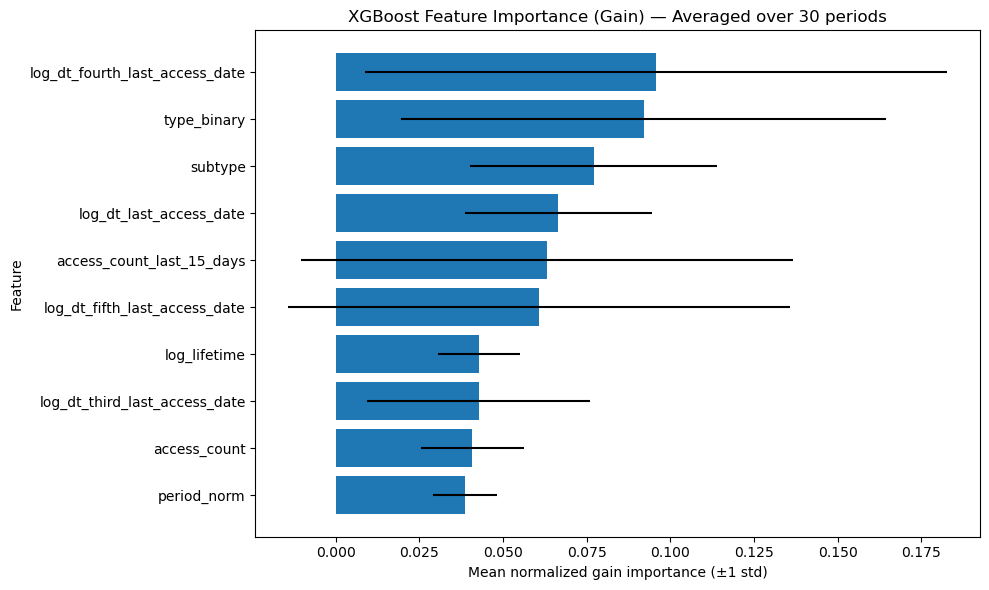

                                mean_importance  std_importance
log_dt_fourth_last_access_date         0.095783        0.086888
type_binary                            0.092029        0.072377
subtype                                0.077067        0.036782
log_dt_last_access_date                0.066460        0.027918
access_count_last_15_days              0.063175        0.073426
log_dt_fifth_last_access_date          0.060742        0.074860
log_lifetime                           0.042861        0.012179
log_dt_third_last_access_date          0.042769        0.033295
access_count                           0.040780        0.015394
period_norm                            0.038617        0.009504


In [67]:
# Assemble matrix: rows = models (periods), cols = features
imp_df = pd.DataFrame(importance_rows)
mean_imp = imp_df.mean(axis=0)
std_imp = imp_df.std(axis=0)

# Sort by mean importance
order = mean_imp.sort_values(ascending=True).index  # ascending for horizontal barh from bottom to top
# Restrict to top N
top_features = mean_imp.nlargest(TOP_N).index
order_top = mean_imp[top_features].sort_values(ascending=True).index

# --- Plot: horizontal bars with std as error bars ---
plt.figure(figsize=(10, max(6, int(TOP_N * 0.35))))
plt.barh(order_top, mean_imp[order_top], xerr=std_imp[order_top], align='center')
plt.xlabel("Mean normalized gain importance (±1 std)")
plt.ylabel("Feature")
plt.title(f"XGBoost Feature Importance (Gain) — Averaged over {len(selected_is)} periods")
plt.tight_layout()
plt.show()

# Optional: inspect aggregated table
agg_table = pd.DataFrame({
    "mean_importance": mean_imp,
    "std_importance": std_imp
}).sort_values("mean_importance", ascending=False)

print(agg_table.head(10))